# Preliminares

## Extração de dados

In [1]:
!gdown 1jD_dF0wUoVfndQtUSVJF7LbhXtswj62Q

Downloading...
From: https://drive.google.com/uc?id=1jD_dF0wUoVfndQtUSVJF7LbhXtswj62Q
To: /content/genius.zip
100% 1.11M/1.11M [00:00<00:00, 18.3MB/s]


In [2]:
!unzip genius.zip

Archive:  genius.zip
   creating: genius/
  inflating: __MACOSX/._genius       
   creating: genius/s05/
  inflating: __MACOSX/genius/._s05   
   creating: genius/s02/
  inflating: __MACOSX/genius/._s02   
   creating: genius/s03/
  inflating: __MACOSX/genius/._s03   
   creating: genius/s04/
  inflating: __MACOSX/genius/._s04   
   creating: genius/s01/
  inflating: __MACOSX/genius/._s01   
   creating: genius/s06/
  inflating: __MACOSX/genius/._s06   
   creating: genius/s08/
  inflating: __MACOSX/genius/._s08   
   creating: genius/s07/
  inflating: __MACOSX/genius/._s07   
  inflating: genius/ref.txt          
  inflating: __MACOSX/genius/._ref.txt  
  inflating: genius/s05/got_s05e09.txt  
  inflating: __MACOSX/genius/s05/._got_s05e09.txt  
  inflating: genius/s05/got_s05e08.txt  
  inflating: __MACOSX/genius/s05/._got_s05e08.txt  
  inflating: genius/s05/got_s05e03.txt  
  inflating: __MACOSX/genius/s05/._got_s05e03.txt  
  inflating: genius/s05/got_s05e02.txt  
  inflating: __MA

In [3]:
import glob

caminho = 'genius/*/*.txt'
arquivos = glob.glob(caminho)

got = {}
for arquivo in sorted(arquivos):
    chave = arquivo[-14:-4]

    with open(arquivo, 'r', encoding = 'utf-8') as f:
        texto = f.read()
    got[chave] = texto

In [4]:
print(got['got_s01e01'])

EPISODE 1 - WINTER IS COMING

[First scene opens with three Rangers riding through a tunnel, leaving the Wall, and going into the woods. (Eerie music in background) One Ranger splits off and finds a campsite full of mutilated bodies, including a child hanging from a tree branch. A birds-eye view shows the bodies arranged in a shield-like pattern. The Ranger rides back to the other two.]

WAYMAR ROYCE: What d’you expect? They’re savages. One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces.

WILL: I’ve never seen wildlings do a thing like this. I’ve never seen a thing like this, not ever in my life.

WAYMAR ROYCE: How close did you get?

WILL: Close as any man would.

GARED: We should head back to the wall.

ROYCE: Do the dead frighten you?

GARED: Our orders were to track the wildlings. We tracked them. They won’t trouble us no more.

ROYCE: You don’t think he’ll ask us how they died? Get back on your horse.

[GARED grumbles.]

WILL: Whate

# Runtime Configurations

In [69]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('figure', titlesize=16)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Criando o Grafo

## Funções de Extração

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
import difflib

#######################################################
def init_graph():
    graph = nx.Graph(name = 'Rede de Relações Game of Thrones')
    return graph

#######################################################
def update_graph(caracters_ep:list,graph):
    G = graph

    # Adicionando vértices
    for caracters in caracters_ep:
        if caracters not in G.nodes:
            G.add_node(caracters)


    # Adicionando Arestas
    for u, v in combinations(caracters_ep,2):
        if G.has_edge(u,v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u,v,weight=1)
    return G

########################################################

def strip_episode(episode:str,caracters:dict,graph):
    ep_caracters = []
    G = graph
    for text in episode.split('\n'):
        # Se não há falas, passe ao proximo
        if ':' not in text or '"' in text:
            continue
        else:
            # Tomando nome do personagem
            name = text.split(':')[0].upper().rstrip()

            # Removendo o tom de resposta
            if '(' in name:
                name = name.split('(')[0].rstrip()

            if '[' in name:
                continue

            # Procurando por correspondências aproximadas
            close_matches = difflib.get_close_matches(name, caracters.keys(), n=1, cutoff=0.8)

            if close_matches:
                name = close_matches[0]

            # Adicionando personagem ao dicionario ou Atualizando Chave
            if name not in caracters:
                # Ignorando marcação de cena
                if 'CUT' in name:
                    continue

                caracters[name] = 1
            else:
                caracters[name] += 1

            # Lista de Personagens do EP
            if name not in ep_caracters:
                ep_caracters.append(name)

            # Atualizando Grafo
            G = update_graph(ep_caracters, G)


######################################################

def run_ep_list(show,caracters:dict = {}):
    graph = init_graph()

    for episode,script in tqdm(show.items()):
        # print(f'ep: {episode}')
        strip_episode(script,caracters,graph)
    return {key: name for key, name in caracters.items() if ',' not in key and '.' not in key and '[' not in key} , graph

#####################################################

def draw_graph(G,title=None):
    plt.figure(figsize=(10,10))

    if title:
        plt.title(title)

    nx.draw_networkx(G,
                     with_labels=False)

    plt.show()


#######################################################

def weight_to_nodes(graph,caracters):
    for name, times_spoken in caracters.items():
        if name in graph.nodes:
            graph.nodes[name]['node_weight'] = times_spoken
    return graph

#######################################################

def get_bad_vertexs(graph):
    bad_vertexs = []
    for v in graph.nodes:
        #Todo vertice ponderado
        if graph.nodes[v]:
            continue

        #Todo vertice sem peso
        else:
            bad_vertexs.append(v)
    return bad_vertexs

#######################################################

def remove_bad_vertexs(graph,bad_vertexs):
    for v in bad_vertexs:
        graph.remove_node(v)
    return graph

#######################################################

def run_job(graph):
    # Tomando Dicionário
    caracters , G_got = run_ep_list(graph)

    # Ponderando os vértices
    G_got = weight_to_nodes(G_got,caracters)

    # Removendo vértices sem peso
    bad_vertexs = get_bad_vertexs(G_got)
    G_got = remove_bad_vertexs(G_got,bad_vertexs)

    return {'Graph': G_got, 'Personagens': caracters, 'Vértices Ruins':bad_vertexs}


#######################################################

def see_nodes_list_weight(graph):
    for node in graph.nodes.values():
        print(node)


######################################################

def plot_network(G,title = None, labels = False):

    fig, ax = plt.subplots(figsize=(14,10))

    if title:
        fig.suptitle(title)

    pos = nx.spring_layout(G, seed = 42)

    nx.draw_networkx(G, pos,with_labels=labels)


###############################################

## Visualização

In [71]:
data = run_job(got)
G_got = data['Graph']

100%|██████████| 73/73 [00:32<00:00,  2.24it/s]


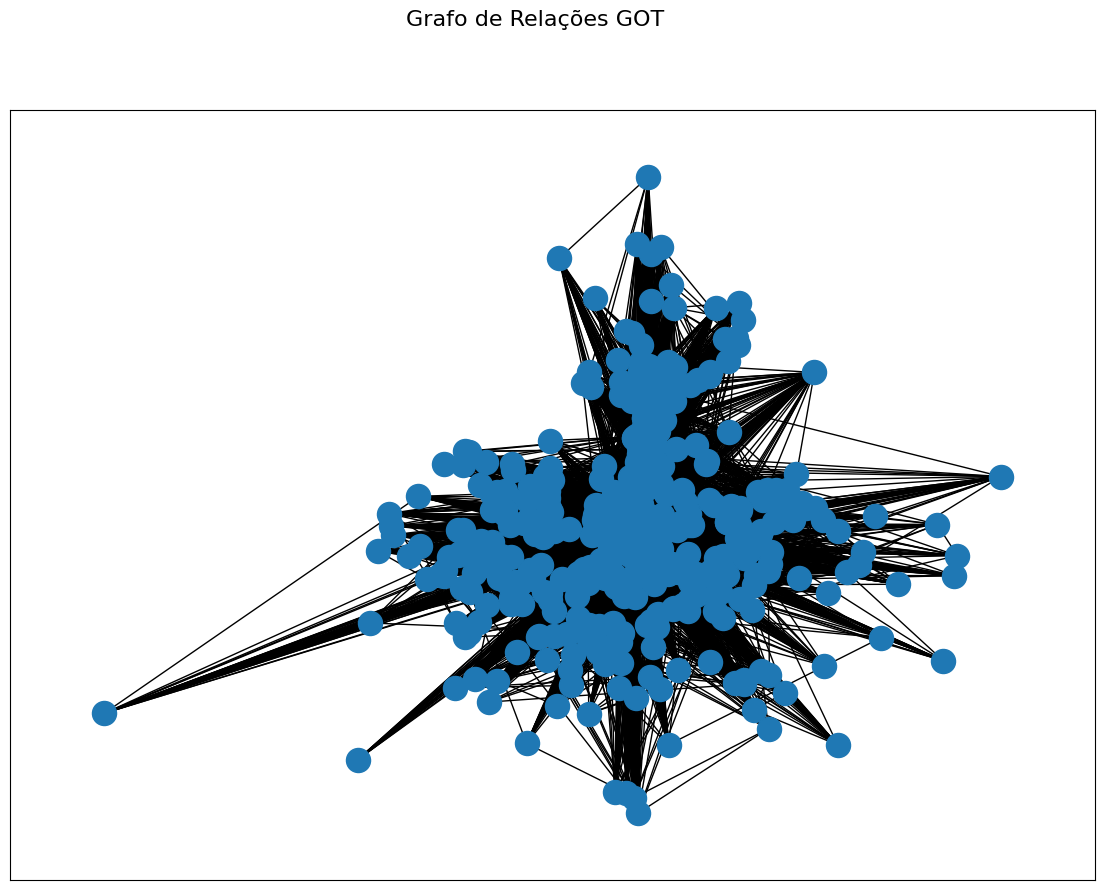

In [72]:
plot_network(G_got,'Grafo de Relações GOT')

plt.show()

## Análise Básica

In [73]:
def see_nodes_properties(graph):
    for node in graph.nodes:
        print(f'Vértice: {node}')
        print(f'Peso: {graph.nodes[node]}')
        print(f'Grau: {graph.degree[node]}')
        print('--------------------')

see_nodes_properties(G_got)

Vértice: WAYMAR ROYCE
Peso: {'node_weight': 2}
Grau: 30
--------------------
Vértice: WILL
Peso: {'node_weight': 10}
Grau: 78
--------------------
Vértice: GARED
Peso: {'node_weight': 7}
Grau: 63
--------------------
Vértice: ROYCE
Peso: {'node_weight': 12}
Grau: 93
--------------------
Vértice: JON
Peso: {'node_weight': 918}
Grau: 369
--------------------
Vértice: SEPTA MORDANE
Peso: {'node_weight': 26}
Grau: 105
--------------------
Vértice: SANSA
Peso: {'node_weight': 747}
Grau: 401
--------------------
Vértice: NED
Peso: {'node_weight': 76}
Grau: 125
--------------------
Vértice: ROBB
Peso: {'node_weight': 239}
Grau: 199
--------------------
Vértice: JON/ROBB
Peso: {'node_weight': 1}
Grau: 30
--------------------
Vértice: CASSEL
Peso: {'node_weight': 3}
Grau: 30
--------------------
Vértice: CATELYN
Peso: {'node_weight': 182}
Grau: 210
--------------------
Vértice: BRAN
Peso: {'node_weight': 347}
Grau: 325
--------------------
Vértice: THEON
Peso: {'node_weight': 423}
Grau: 339
---

In [74]:
def degree_properties(graph):
    print(f'Número de Vértices: {len(graph.nodes)}')
    print(f'Número de Arestas: {len(graph.edges)}')

    print(f'Grau Máximo: {max(dict(graph.degree).values())}')
    print(f'Grau Mínimo: {min(dict(graph.degree).values())}')
    print(f'Grau Médio: {sum(dict(graph.degree).values())/len(graph.nodes)}')

    # Probabilidade de que os vizinhos de um nó estejam conectados entre si
    print(f'Coeficiente de Clustering: {nx.average_clustering(graph)}')

    # Têndencia de Similiaridade por Grau:
    print(f'Coeficiente de Assortatividade: {nx.degree_pearson_correlation_coefficient(graph)}')

    # Conectividade
    print(f'É conexo: {nx.is_connected(graph)}')
    if not nx.is_connected(graph):
        print(f'Número de Componentes conexas: {nx.number_connected_components(graph)}')

    # Densidade
    print(f'Densidade: {nx.density(graph)}')

    # Cintura
    print(f'Cintura: {nx.radius(graph)}')
    print(f'Diâmetro: {nx.diameter(graph)}')

    # Transitividade
    print(f'Transitividade: {nx.transitivity(graph)}')

    # Comprimento de Caminho médio
    print(f'Comprimento de Caminho Médio: {nx.average_shortest_path_length(graph)}')

def see_nodes_properties(graph):
    for node in graph.nodes:
        print(f'Vértice: {node}')
        print(f'Peso: {graph.nodes[node]}')
        print(f'Grau: {graph.degree[node]}')
        print('--------------------')

def see_edges_properties(graph):
    for edge in graph.edges:
        print(f'Aresta: {edge}')
        print(f'Peso: {graph[edge[0]][edge[1]]["weight"]}')
        print('--------------------')

def centrality_properties(graph):
    print(f'Centralidade: {nx.betweenness_centrality(graph)}')
    print(f'Centralidade por Grau: {nx.degree_centrality(graph)}')
    print(f'Centralidade de Proximidade: {nx.closeness_centrality(graph)}')
    print(f'Centralidade de Autovalor: {nx.eigenvector_centrality(graph)}')

print('Propriedades de G:')
degree_properties(G_got)
print()
print('Propriedades de Centralidade: ')
centrality_properties(G_got)

Propriedades de G:
Número de Vértices: 527
Número de Arestas: 24078
Grau Máximo: 431
Grau Mínimo: 17
Grau Médio: 91.37760910815939
Coeficiente de Clustering: 0.7965083806382948
Coeficiente de Assortatividade: -0.27207008369167957
É conexo: True
Densidade: 0.17372169031969467
Cintura: 2
Diâmetro: 3
Transitividade: 0.4515517146908575
Comprimento de Caminho Médio: 1.8403907619714144

Propriedades de Centralidade: 
Centralidade: {'WAYMAR ROYCE': 0.0, 'WILL': 0.00018395138867845464, 'GARED': 0.0003031095874428167, 'ROYCE': 0.0005386932346497746, 'JON': 0.021506469082364258, 'SEPTA MORDANE': 0.001255180787682005, 'SANSA': 0.024010742379654636, 'NED': 0.0017032596173730012, 'ROBB': 0.002647784912055739, 'JON/ROBB': 0.0, 'CASSEL': 0.0, 'CATELYN': 0.0031047120063434227, 'BRAN': 0.013031675587652643, 'THEON': 0.014979582868900412, 'JAIME': 0.022084845673712362, 'CERSEI': 0.024687313525049617, 'MAESTER LUWIN': 0.0030824176535856314, 'LUWIN': 0.0011960582760808791, 'ARYA': 0.0229881037837414, 'ROB

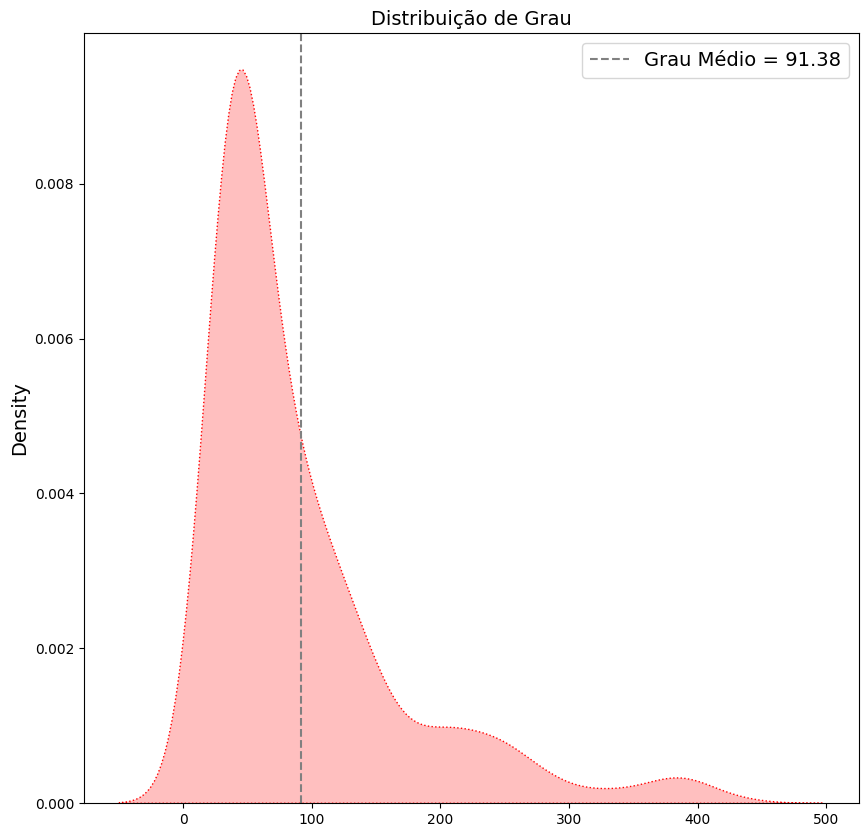

In [75]:
plt.figure(figsize=(10,10))

plt.title('Distribuição de Grau')

sns.kdeplot(list(dict(G_got.degree).values()),
            bw_adjust=1,
            fill=True,
            color='red',
            linestyle='dotted')

mean_degree = sum(dict(G_got.degree).values())/ len(G_got.nodes)


plt.axvline(mean_degree , color='gray', linestyle='--', label = f'Grau Médio = {mean_degree:.2f}')


plt.legend()
plt.show()

# Visualização geral de Centralidade

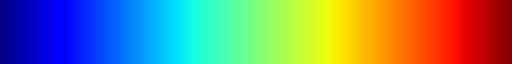

In [76]:
plt.cm.jet

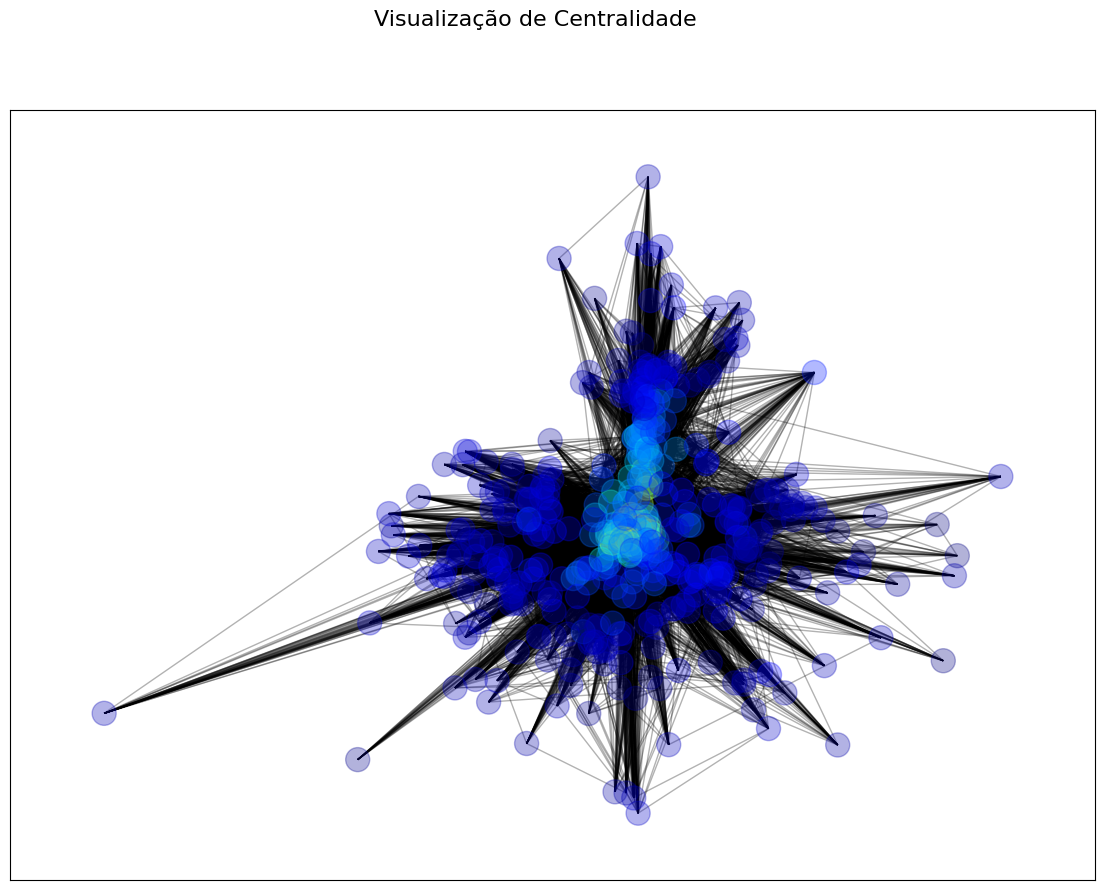

In [77]:
def plot_network_with_degree(G, degrees: dict, cmap = False, title = None):

    fig, ax = plt.subplots(figsize=(14,10))

    pos = nx.spring_layout(G,
                           seed = 42)


    if title:
        fig.suptitle(title)

    if cmap:
        nx.draw_networkx(G,
                        pos,
                        cmap = plt.cm.jet,
                        node_color = list(degrees.values()),
                        nodelist = degrees.keys(),
                        with_labels=False,
                        alpha= 0.3)

    else:
        nx.draw_networkx(G,
                        pos,
                        node_color = list(degrees.values()),
                        nodelist = degrees.keys(),
                        with_labels=False,
                        alpha=0.3)

    plt.show()

plot_network_with_degree(G_got,
                         nx.degree_centrality(G_got),
                         cmap=True,
                         title = 'Visualização de Centralidade')



---


Para considerar o peso de cada vértice, criaremos um novo atributo chamado 'importance' onde


$$ im_v = d_v * w_v$$

Após isso, colocaremos entre 0-1 para facilitar a visualização

---



In [78]:
for node in G_got.nodes:

    G_got.nodes[node]['importance'] = G_got.degree[node] * G_got.nodes[node]['node_weight']

    print(f'Vértice: {node}')
    print(f'Importance: {G_got.nodes[node]["importance"]}')

    print('--------------------')

Vértice: WAYMAR ROYCE
Importance: 60
--------------------
Vértice: WILL
Importance: 780
--------------------
Vértice: GARED
Importance: 441
--------------------
Vértice: ROYCE
Importance: 1116
--------------------
Vértice: JON
Importance: 338742
--------------------
Vértice: SEPTA MORDANE
Importance: 2730
--------------------
Vértice: SANSA
Importance: 299547
--------------------
Vértice: NED
Importance: 9500
--------------------
Vértice: ROBB
Importance: 47561
--------------------
Vértice: JON/ROBB
Importance: 30
--------------------
Vértice: CASSEL
Importance: 90
--------------------
Vértice: CATELYN
Importance: 38220
--------------------
Vértice: BRAN
Importance: 112775
--------------------
Vértice: THEON
Importance: 143397
--------------------
Vértice: JAIME
Importance: 352692
--------------------
Vértice: CERSEI
Importance: 374738
--------------------
Vértice: MAESTER LUWIN
Importance: 5586
--------------------
Vértice: LUWIN
Importance: 7992
--------------------
Vértice: ARYA
Imp

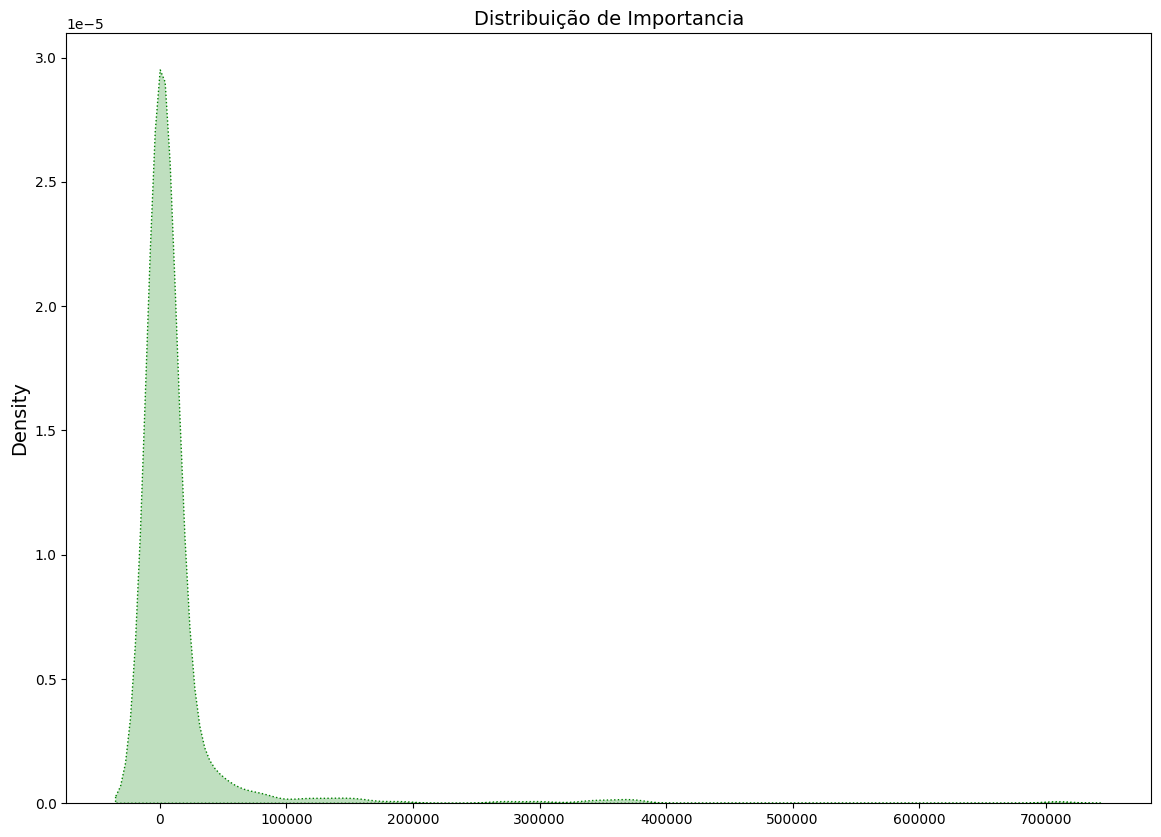

In [79]:
plt.figure(figsize=(14,10))

plt.title('Distribuição de Importancia')

sns.kdeplot(list(nx.get_node_attributes(G_got,'importance').values()),
            bw_adjust=0.8,
            fill=True,
            color='green',
            linestyle='dotted')
plt.show()

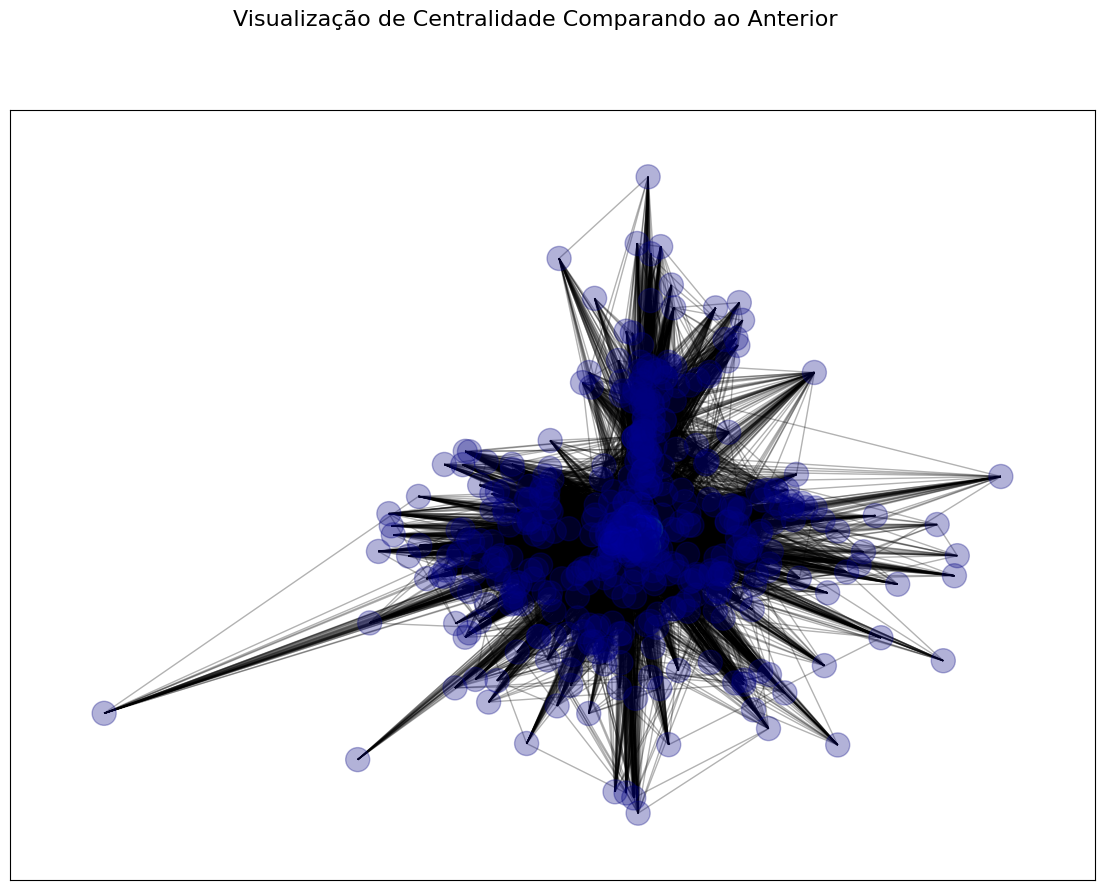

In [80]:
plot_network_with_degree(G_got,
                         nx.get_node_attributes(G_got,'importance'),
                         cmap=True,
                         title = 'Visualização de Centralidade Comparando ao Anterior')

# Construindo Árvore geradora Máxima

Para considerarmos os pesos das arestas, usaremos também uma visualização por árvore geradora máxima, considerando as arestas de maior peso.

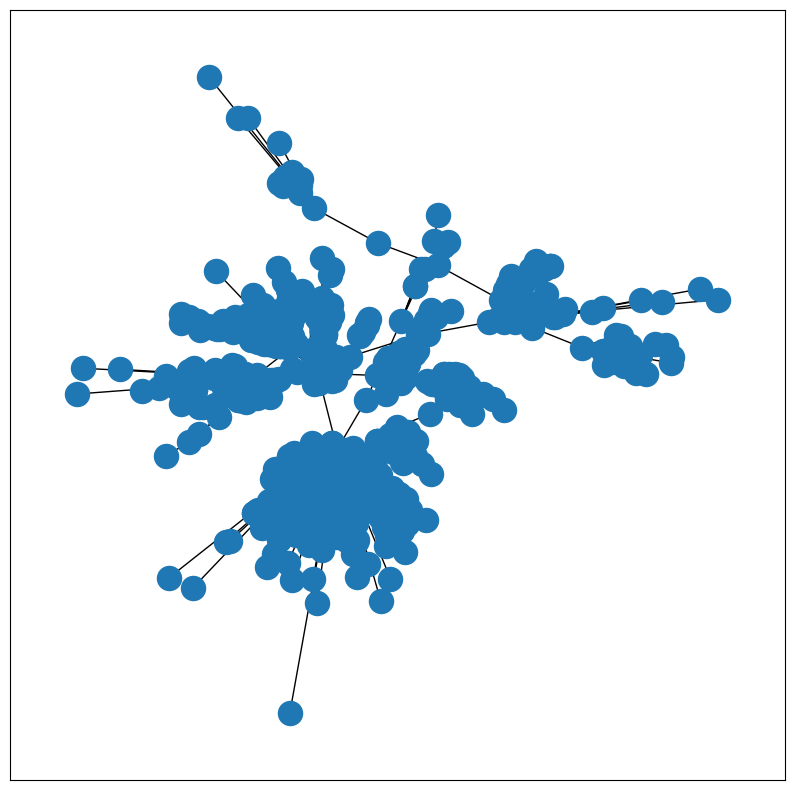

In [81]:
max_edge_spanning_tree_G = nx.maximum_spanning_edges(G_got, algorithm='kruskal', data=True)
G_max_spanning_tree = nx.maximum_spanning_tree(G = G_got,weight='weight',algorithm='kruskal')
draw_graph(G_max_spanning_tree)

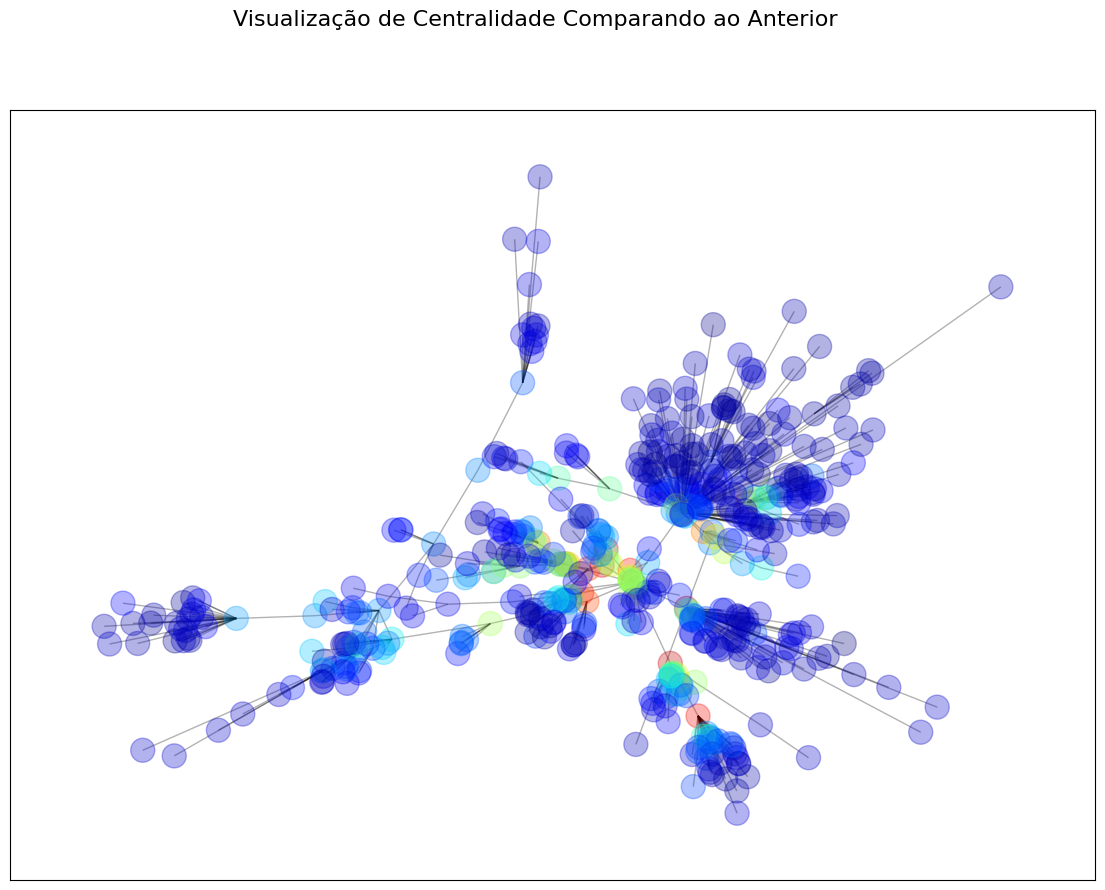

In [82]:
plot_network_with_degree(G_max_spanning_tree,
                         nx.degree_centrality(G_got),
                         cmap=True,
                         title = 'Visualização de Centralidade Comparando ao Anterior')

Consideraremos as duas análises para a tomada de decisão.

### Por centralidade

In [83]:
dg_centrality = nx.degree_centrality(G_got)
sorted_dg_centrality = dict(sorted(dg_centrality.items(), key=lambda item: item[1], reverse=True))
print(f'Protagonista segundo centralidade de grau do grafo como um todo: {list(sorted_dg_centrality.keys())[0]}')

Protagonista segundo centralidade de grau do grafo como um todo: TYRION


In [84]:
eg_centrality = nx.eigenvector_centrality(G_got)
sorted_eg_centrality = dict(sorted(eg_centrality.items(), key=lambda item: item[1], reverse=True))
print(f'Protagonista segundo centralidade de autovalor do grafo como um todo: {list(sorted_eg_centrality.keys())[0]}')

Protagonista segundo centralidade de autovalor do grafo como um todo: TYRION


In [85]:
dg_centrality_max_spanning_tree = nx.degree_centrality(G_max_spanning_tree)
sorted_dg_centrality_max_spanning_tree = dict(sorted(dg_centrality_max_spanning_tree.items(), key=lambda item: item[1], reverse=True))
print(f'Protagonista segundo centralidade de grau da árvore geradora máxima: {list(sorted_dg_centrality_max_spanning_tree.keys())[0]}')

Protagonista segundo centralidade de grau da árvore geradora máxima: JON


In [86]:
eg_centrality_max_spanning_tree = nx.eigenvector_centrality(G_max_spanning_tree)
sorted_eg_centrality_max_spanning_tree = dict(sorted(eg_centrality_max_spanning_tree.items(), key=lambda item: item[1], reverse=True))
print(f'Protagonista segundo centralidade de autovalor da árvore geradora máxima: {list(sorted_eg_centrality_max_spanning_tree.keys())[0]}')

Protagonista segundo centralidade de autovalor da árvore geradora máxima: JON


### Pelo Atributo de Importância

In [87]:
importance_dict = dict(nx.get_node_attributes(G_got,'importance'))
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
print(f'Protagonista segundo Atributo IMPORTANCE de grau do grafo como um todo: {list(sorted_importance_dict.keys())[0]}')

Protagonista segundo Atributo IMPORTANCE de grau do grafo como um todo: TYRION


In [88]:
importance_dict_max_spanning_tree = dict(nx.get_node_attributes(G_max_spanning_tree,'importance'))
sorted_importance_dict_max_spanning_tree = dict(sorted(importance_dict_max_spanning_tree.items(), key=lambda item: item[1], reverse=True))
print(f'Protagonista segundo Atributo IMPORTANCE da árvore geradora máxima: {list(sorted_importance_dict_max_spanning_tree.keys())[0]}')

Protagonista segundo Atributo IMPORTANCE da árvore geradora máxima: TYRION


Logo, pela análise majoritária, o nosso protagonista é o **Tyrion**


---



In [89]:
import pandas as pd

In [90]:
G_got.nodes['TYRION']

{'node_weight': 1646, 'importance': 709426}

In [96]:
arestas_tyrion = tuple(G_got.edges('TYRION',data=True))
aresta_max = max(arestas_tyrion, key=lambda x: x[2]['weight'])
biggest_relation = aresta_max[1]

In [97]:
aresta_max

('TYRION', 'CERSEI', {'weight': 10034})

In [98]:
import pandas as pd

arestas_tyrion = tuple(G_got.edges('TYRION',data=True))
aresta_max = max(arestas_tyrion, key=lambda x: x[2]['weight'])
biggest_relation = aresta_max[1]

data_protagonista = {'Personagem': 'Tyrion Lanister',
                     'Peso': G_got.nodes['TYRION']['node_weight'],
                     'Importancia': str(G_got.nodes['TYRION']['importance']),
                     'Grau' : G_got.degree['TYRION'],
                     'Maior Relação': biggest_relation}

pd.DataFrame(data_protagonista, index=[1])

,Personagem,Peso,Importancia,Grau,Maior Relação
1,Tyrion Lanister,1646,709426,431,CERSEI


# Limpando Visualização:

In [100]:
G_safe_copy = G_got.copy()

In [111]:
list(map(lambda x: str(x) , list(range(len(G_safe_copy.nodes)))))

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

In [118]:
nodes_to_remove = [node for node, attr in G_got.nodes(data=True) if attr.get('node_weight', 0) < 150]
G_got.remove_nodes_from(nodes_to_remove)

In [125]:
labels = list(G_got.nodes)
print(f'Vértice Relativo ao Tyrion: {labels.index("TYRION")}')

Vértice Relativo ao Tyrion: 9


In [156]:
def plot_network_with_degree_final(graph, degrees: dict, cmap = False, title = None):

    fig, ax = plt.subplots(figsize=(14,10))

    # pos = nx.spring_layout(graph,
    #                        seed = 42)

    # pos = nx.kamada_kawai_layout(graph)

    pos = nx.circular_layout(graph)

    # pos = nx.spectral_layout(graph)

    # pos = nx.shell_layout(graph)

    labs = {node: str(i) for i, node in enumerate(graph.nodes)}

    if title:
        fig.suptitle(title)

    if cmap:
        nx.draw_networkx(graph,
                        pos,
                        cmap = plt.cm.plasma,
                        node_color = list(degrees.values()),
                        nodelist = degrees.keys(),
                        with_labels=True,
                        labels = labs,
                        alpha=0.8)

    else:
        nx.draw_networkx(graph,
                        pos,
                        nodelist = degrees.keys(),
                        with_labels=True,
                        labels = labs,
                        alpha=0.8)

    nx.draw_networkx_edges(graph, pos , alpha = 0.1)

    plt.show()

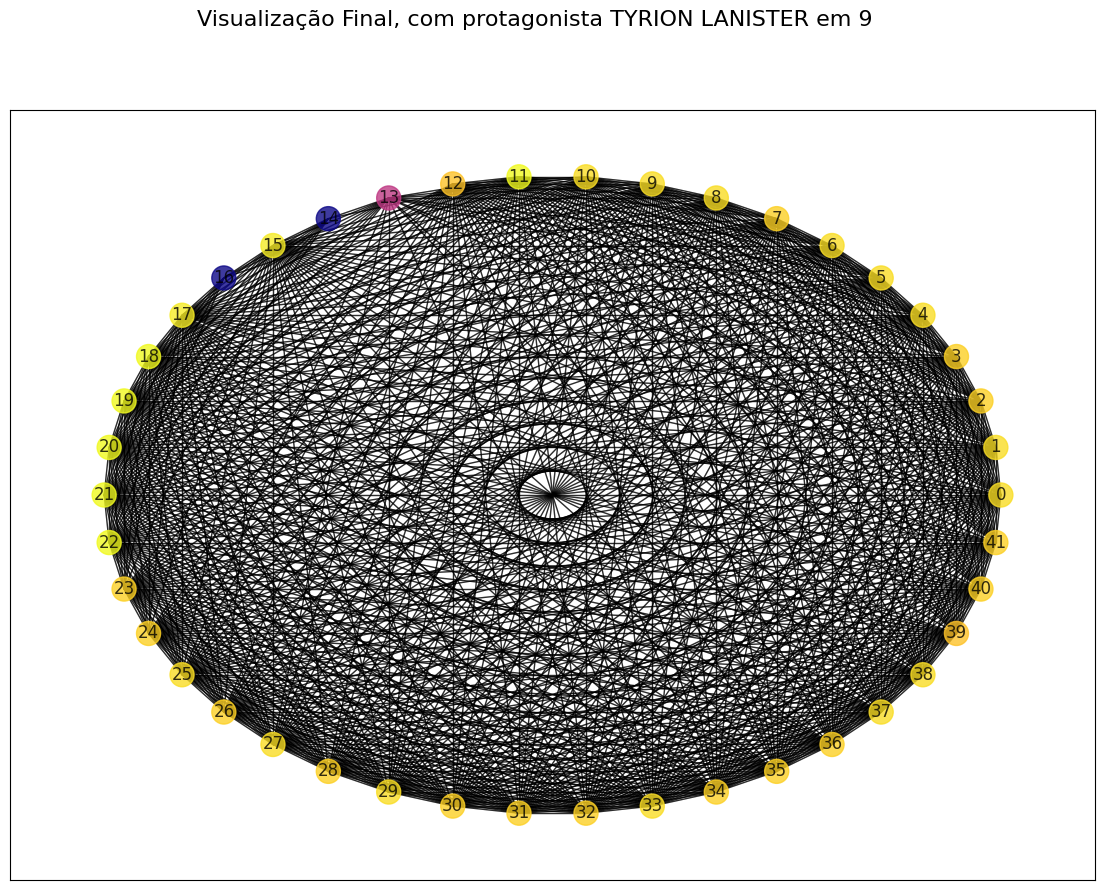

<Figure size 640x480 with 0 Axes>

In [157]:
plot_network_with_degree_final(G_got,
                               nx.degree_centrality(G_got),
                               cmap=True,
                               title = f'Visualização Final, com protagonista TYRION LANISTER em {labels.index("TYRION")}')

plt.savefig('got_final.png')